[한국어와 NLTK, Gensim의 만남 by Lucy Park](https://www.lucypark.kr/docs/2015-pyconkr/#1)  
[A Neural Probabilistic Language Model](http://papers.nips.cc/paper/1839-a-neural-probabilistic-language-model.pdf)  
[Yoshua Bengio's A Neural Probabilistic Language Model in 500 words](https://medium.com/@satyavasanth_57235/yoshua-bengios-a-neural-probabilistic-language-model-in-500-words-665b6e64ade6)  
[word2vec](https://code.google.com/archive/p/word2vec/)  
[ratsgo's blog-Word2Vec으로 문장 분류하기](https://ratsgo.github.io/natural%20language%20processing/2017/03/08/word2vec/)  
[GloVe:Global vectors for word representation](https://www.slideshare.net/keunbongkwak/gloveglobal-vectors-for-word-representation)  
[텐서플로우 문서 한글 번역본 - 단어들의 벡터 표현](https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/tutorials/word2vec/)  
아래 내용은 상기 링크를 정리한것.

# 감성분석 (feat. KoNLPy)

## Co-occurence
<center>Co-occurence</center>
<center>두 단어가 정해진 구간 내에서 동시에 등장한다.</center>

In [ ]:
# ex
documents = [["나는", "파이썬", "이", "좋다"], ["나는", "R", "이", "좋다"]]

### Term-document matrix
$$
X_{td} \in \mathbb R^{|V| \times M}
$$
**한 문서**에 같이 등장하면 비슷한 단어이다.

In [ ]:
x_td = [[1, 1], # 나는
        [1, 0], # 파이썬
        [0, 1], # R
        [1, 1], # 이
        [1, 1]] # 좋다

즉, 계산 해야될 벡터가 문서(document) 개수의 M개에 비례한다.

### Term-term matrix
$$
X_{tt} \in \mathbb R^{|V| \times |V|}
$$
단어가 **문맥** 내에 같이 존재하면 비슷한 단어  
앞뒤로 단어를 두 개씩 보는 경우 (문맥의 길이 == 5):

In [ ]:
x_tt = [[0, 1, 1, 2, 0], # 나는
       [1, 0, 0, 1, 1],  # 파이썬
       [1, 0, 0, 1, 1],  # R
       [2, 1, 1, 0, 2],  # 이
       [0, 1, 1, 2, 0]]  # 좋다

문맥의 길이가 짧을 수록 syntactic 이고 길 수록 semantic 정보를 포함한다.

https://www.lucypark.kr/docs/2015-pyconkr/#27

## Word2Vec

https://ratsgo.github.io/natural%20language%20processing/2017/03/08/word2vec/

## Doc2Vec

In [15]:
documents = [
    ['왕자', '가', '공주', '를', '좋아한다'],
    ['공주', '가', '왕자', '를', '좋아한다'],
    ['시녀', '가', '왕자', '를', '싫어한다'],
    ['공주', '가', '시녀', '를', '싫어한다'],
    ['시녀', '가', '왕자', '를', '독살한다'],
    ['시녀', '가', '공주', '를', '독살한다']
]
# 단어간의 중복을 제거하고 하나의 집합(set)으로 합친다.
words = set(sum(documents, []))
print(words)
print(type(words))

{'가', '를', '시녀', '공주', '독살한다', '왕자', '좋아한다', '싫어한다'}
<class 'set'>


term_frequency 예시:
* 문서 벡터의 크기가 단어의 수 $|V|$와 같고 원소들은 양의 정수이다.  
  
아직 실행되지 않는다.

In [ ]:
def term_frequency(document):
    return vectors

vectors = [term_frequency(doc) for doc in documents]
print(vectors)

doc2vec 예시:
* 문서 벡터의 크기가 단어의 수 $|V|$보다 작고 원소들은 실수이다.  
  
아직 실행되지 않는다.

In [ ]:
def doc2vec(document):
    return vector
vectors = [doc2vec(doc) for doc in documents]
print(vectors)
# => {
#       'S1': [-0.01599941, 0.02135301, 0.0927715],
#       'S2': [0.02333261, 0.00211833, 0.00254255],
#       'S3': [-0.00117272, -0.02043504, 0.00593186],
#       'S4': [0.0089237, -0.00397806, -0.13199195],
#       'S5': [0.02555059, 0.01561624, 0.03603476],
#       'S6': [-0.02114407, -0.01552016, 0.01289922]
#    }

## Data preprocessing

In [2]:
def read_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:] # header 제외 변수
    return data

def tag_writing_data(filename):
    open(filename, 'w', encoding='utf-8')


train_data = read_data('ratings_train.txt')
test_data = read_data('ratings_test.txt')

제대로 읽혔는지 확인

In [3]:
print("train")
print(len(train_data))
print(len(train_data[0]))
print("test")
print(len(test_data))
print(len(test_data[0]))

train
150000
3
test
50000
3


형태소로 토크나이징

In [4]:
from konlpy.tag import Twitter
pos_tagger = Twitter()

def tokenize(doc):
    # norm, stem은 optional
    return ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]
"""
row[0] : id
row[1] : document
row[2] : label
for row in train_data:
    print("id : ",row[0])
    print("document : ", row[1])
    print("label : ", row[2])
"""

train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
test_docs = [(tokenize(row[1]), row[2]) for row in test_data]

# 확인
print(train_docs[0])

(['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증/Noun', '나다/Verb', '목소리/Noun'], '0')


In [5]:
# # 형태소 토크나이징된 파일 저장, 로드
# import pandas as pd
# import numpy as np

# train_docs.to_csv("train_docs.txt", encoding='utf-8')
# test_docs.to_csv("test_docs.txt", encoding='utf-8')

# train_read = pd.read_csv("train_docs.csv", encoding='utf-8')
# print(train_read[0])

* 형태소로 꼭 나눠야 하는 이유
    * 데이터가 충분하면 어절 단위의 분석이 가능하지만 데이터가 적으므로 형태소를 나눠야 한다.
    * [시인 뉴럴](https://github.com/carpedm20/poet-neural)은 음절 단위의 분석이다.
    * 토큰의 단위는 선택의 문제
* 품사(POS) 태그를 붙여야 하는 이유
    * 선택의 문제이나 여기서는 사용
    * 품사를 태깅해두면 동음이의어를 구분할 수 있다는 장점이 있다.
        * ex '은/Josa' vs '은/Noun'

## Data exploration
* 데이터의 코퍼스가 어떤 특징들을 가지고 있는지 확인해본다.
* Training data의 token을 모은다.
* token ex) 
    * ['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증/Noun', '나다/Verb', '목소리/Noun']

In [6]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2194536


* nltk.Text()를 써본다. (Exploration이 편하다)
    * 원래 단일 document를 분석할 때는 훨씬 풍부한 기능들을 사용할 수 있지만, 여기서는 그 중 몇 가지만 살펴본다.

In [7]:
import nltk
text = nltk.Text(tokens, name = 'NMSC')
print(text)

<Text: NMSC>


In [8]:
print(len(text.tokens)) # tokens의 숫자
print(len(set(text.tokens))) # unique tokens의 숫자
print(text.vocab().most_common(10)) # 동사 중 Top 10

2194536
48765
[('./Punctuation', 68630), ('영화/Noun', 51365), ('하다/Verb', 50281), ('이/Josa', 39123), ('보다/Verb', 34764), ('의/Josa', 30480), ('../Punctuation', 29055), ('에/Josa', 27108), ('가/Josa', 26696), ('을/Josa', 23481)]


토큰에 대한 그래프

In [9]:
text.plot(50)

<Figure size 640x480 with 1 Axes>

한글이 깨진다.

In [10]:
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

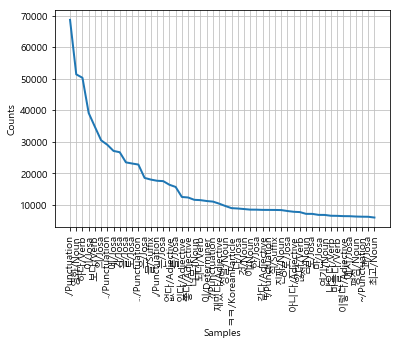

In [11]:
text.plot(50)

## Sentiment classification with term-existance
* 아래는 term이 문서에 존재하는지의 유무에 따라 분류를 해본다.

최빈도 단어 200개를 피쳐로 사용

In [12]:
selected_words = [f[0] for f in text.vocab().most_common(200)]

def term_exists(doc):
    return{'exists({})'.format(word): (word in set(doc)) for word in selected_words}

# 시간 단축을 위해 training corpus의 일부만 사용 할수 있으나 성능은 떨어질 가능성이 있다.
train_docs = train_docs[:10000]

train_xy = [(term_exists(d), c) for d, c in train_docs]
test_xy = [(term_exists(d), c) for d, c in test_docs]

시도해볼 만한것.
* 최빈도 단어들은 의미가 없을 수 있다. 최상위 50개를 제거하고 분석하면?
* TF, TF-IDF의 성능은?
* 코드 최적화(sparse matrix) 또는 scikit-learn의 TfidfVectorizer()를 이용! 